# Libraries Import 📚

In [31]:
import os
import glob

import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader

from datasets import Dataset

from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer,DataCollatorForTokenClassification,get_scheduler


import matplotlib.pyplot as plt

import evaluate

from tqdm import tqdm

import numpy as np


# File Parsing 📝

In [32]:
def read_conllx(filepath):
    """
    Reads a CoNLL-X formatted file and extracts tokens and tags for each sentence.

    Args:
        filepath (str): Path to the CoNLL-X file.

    Returns:
        tuple: A tuple containing two lists:
            - sentences_tokens: List of token lists for each sentence.
            - sentences_tags: List of tag lists for each sentence.
    """
    sentences_tokens = []
    sentences_tags = []
    with open(filepath, 'r', encoding='utf8') as f:
        tokens, tags = [], []
        for line in f:
            line = line.strip()
            if not line:  # End of a sentence
                if tokens:
                    sentences_tokens.append(tokens)
                    sentences_tags.append(tags)
                    tokens, tags = [], []  # Reset for the next sentence
            else:
                parts = line.split()
                if len(parts) >= 5:  # Ensure the line has enough parts
                    tokens.append(parts[1])  # Token is in the second column
                    tags.append(parts[4])    # Tag is in the fifth column
        # Append the last sentence if the file doesn't end with a blank line
        if tokens:
            sentences_tokens.append(tokens)
            sentences_tags.append(tags)
    return sentences_tokens, sentences_tags


def load_data_from_folders(folders, base_path="wsj"):
    """
    Loads tokens and tags from multiple folders containing CoNLL-X files.

    Args:
        folders (list): List of folder names to process.
        base_path (str): Base directory containing the folders.

    Returns:
        tuple: A tuple containing two lists:
            - all_tokens: List of token lists for all sentences.
            - all_tags: List of tag lists for all sentences.
    """
    all_tokens = []
    all_tags = []
    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        # Iterate through all .conllx files in the folder
        for file in glob.glob(os.path.join(folder_path, "*.conllx")):
            tokens, tags = read_conllx(file)  # Read tokens and tags from the file
            all_tokens.extend(tokens)  # Add tokens to the global list
            all_tags.extend(tags)      # Add tags to the global list
    return all_tokens, all_tags


# Data Split 🗂️

In [33]:
train_folders = [f"{i:02d}" for i in range(0, 19)]     # Folders 00 to 18
val_folders   = [f"{i:02d}" for i in range(19, 22)]    # Folders 19 to 21
test_folders  = [f"{i:02d}" for i in range(22, 25)]    # Folders 22 to 24


train_tokens, train_tags = load_data_from_folders(train_folders, base_path="wsj")
val_tokens, val_tags = load_data_from_folders(val_folders, base_path="wsj")
test_tokens, test_tags = load_data_from_folders(test_folders, base_path="wsj")

data_train = {"tokens": train_tokens, "pos_tags": train_tags}
data_val   = {"tokens": val_tokens, "pos_tags": val_tags}
data_test  = {"tokens": test_tokens, "pos_tags": test_tags}

print(f"Train size: {len(train_tokens)}")
print(f"Validation size: {len(val_tokens)}")
print(f"Test size: {len(test_tokens)}")




Train size: 38219
Validation size: 5527
Test size: 5462


# Load Tokenizer and Model 🤖

In [34]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased", use_fast=True)

label_list = sorted({tag for tags in data_train["pos_tags"] for tag in tags})
label_to_id = {label: i for i, label in enumerate(label_list)}

#use bert for token classification
model = AutoModelForTokenClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=len(label_list), label2id=label_to_id, id2label={i: label for i, label in enumerate(label_list)})
#set the device to cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(device)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


# Preprocessing 📝

In [35]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    all_labels = []
    for i, labels in enumerate(examples["pos_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Ignore special tokens
            elif word_idx != previous_word_idx:
                # Assign the label for the first token of the word
                label_ids.append(label_to_id.get(labels[word_idx], -100))
            else:
                # Assign -100 to subsequent tokens of the same word
                label_ids.append(-100)
            previous_word_idx = word_idx
        all_labels.append(label_ids)
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs

# Convert datasets to Hugging Face Dataset objects
train_dataset = Dataset.from_dict(data_train)
val_dataset = Dataset.from_dict(data_val)
test_dataset = Dataset.from_dict(data_test)

# Apply the tokenization and alignment function
train_dataset = train_dataset.map(tokenize_and_align_labels, batched=True)
val_dataset = val_dataset.map(tokenize_and_align_labels, batched=True)
test_dataset = test_dataset.map(tokenize_and_align_labels, batched=True)

# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Map: 100%|██████████| 5462/5462 [00:00<00:00, 5574.81 examples/s]

Train dataset size: 38219
Validation dataset size: 5527
Test dataset size: 5462


# Training 🦾

C:\Users\rinal\AppData\Local\Temp\ipykernel_12024\2668321336.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.202600,0.092358
2,0.072800,0.085909
3,0.058400,0.085673


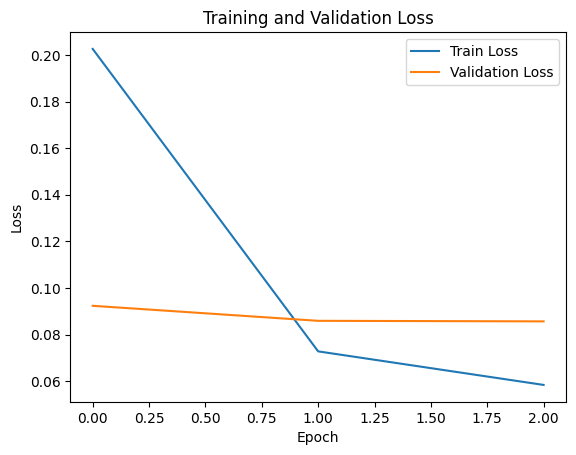

In [36]:
# Set the format for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # evaluate at the end of every epoch
    logging_strategy="epoch",       # log metrics at every epoch
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    optim="adamw_torch",
    greater_is_better=False,
    report_to="none"
    #save the model with the best validation loss
    save_strategy="epoch",
)

# Define the data collator
data_collator = DataCollatorForTokenClassification(tokenizer)
# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
# Wrap the training process with tqdm for progress tracking
trainer.train()
# Save the model
trainer.save_model("./results")
# Save the tokenizer
tokenizer.save_pretrained("./results")

# # save in an array the training loss and the validation loss
train_loss = []
val_loss = []

# get the training loss and validation loss from the trainer
for log in trainer.state.log_history:
    if "loss" in log:
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        val_loss.append(log["eval_loss"])

# plot the training loss and validation loss
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("loss.png")
plt.show()

# Evalutation 👨‍🏫

In [39]:
# Load evaluation metrics
metric_f1 = evaluate.load("f1")
metric_acc = evaluate.load("accuracy")

# Get predictions from the model on the validation dataset
predictions, labels, _ = trainer.predict(test_dataset)

# Convert predictions to label IDs
true_predictions = np.argmax(predictions, axis=2).flatten()
true_labels = labels.flatten()

# Filter out ignored index (-100) in labels
valid_indices = true_labels != -100
true_predictions = true_predictions[valid_indices]
true_labels = true_labels[valid_indices]

# Compute F1 score
f1_result = metric_f1.compute(predictions=true_predictions, references=true_labels, average="weighted")
print(f"F1 Score: {f1_result['f1']}")

# Compute accuracy
acc_result = metric_acc.compute(predictions=true_predictions, references=true_labels)
print(f"Accuracy: {acc_result['accuracy']}")

# Compute balanced accuracy
balanced_acc = np.mean([
    acc_result['accuracy'] if label != -100 else 0
    for label in np.unique(true_labels)
])
print(f"Balanced Accuracy: {balanced_acc}")





F1 Score: 0.9745570072158877
Accuracy: 0.9740000308513428
Balanced Accuracy: 0.9740000308513429


In [45]:
#compute classification report
from sklearn.metrics import classification_report
# Get the classification report
report = classification_report(
    true_labels,
    true_predictions,
    target_names=[label_list[i] for i in np.unique(true_labels) if i != -100],
    output_dict=True
)

#save classification report to a file txt
with open("classification_report.txt", "w") as f:
    f.write(classification_report(
        true_labels,
        true_predictions,
        target_names=[label_list[i] for i in np.unique(true_labels) if i != -100]
    ))
    
print(report)


{'#': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 15.0}, '$': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 943.0}, "''": {'precision': 0.999043062200957, 'recall': 0.999043062200957, 'f1-score': 0.999043062200957, 'support': 1045.0}, ',': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 6876.0}, '-LRB-': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 186.0}, '-RRB-': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 187.0}, '.': {'precision': 0.9998141954663694, 'recall': 1.0, 'f1-score': 0.9999070891015516, 'support': 5381.0}, ':': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 752.0}, 'CC': {'precision': 0.9972290640394089, 'recall': 0.9966153846153846, 'f1-score': 0.9969221298861188, 'support': 3250.0}, 'CD': {'precision': 0.9915113871635611, 'recall': 0.9929504457806344, 'f1-score': 0.9922303946959494, 'support': 4823.0}, 'DT': {'precision': 0.9954333810888252, 'recall': 0.9940981847447018, 'f

[[  15    0    0 ...    0    0    0]
 [   0  943    0 ...    0    0    0]
 [   0    0 1044 ...    0    0    0]
 ...
 [   0    0    0 ...   37    0    0]
 [   0    0    0 ...    0  303    0]
 [   0    0    0 ...    0    0 1074]]


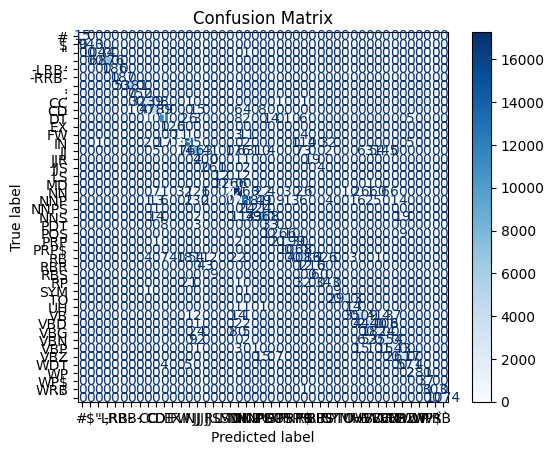

In [ ]:
#compute confusion matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

#compute confusion matrix
cm = confusion_matrix(true_labels, true_predictions, labels=range(len(label_list)))

#plot confusion matrix
print(cm)


# Model Saving 💾

In [ ]:
# save model with torch.save(model.state_dict(), "model.pt")
torch.save(model, "model.pt")